## Redes Neuronales Convolucionales (Transfer Learning y Fine Tuning)

En este laboratorio, nos adentraremos en un proceso de entrenamiento de un modelo existente utilizando una técnica fundamental en aprendizaje profundo: la transferencia de conocimientos (transfer learning), junto con la técnica de fine-tuning (ajuste fino). Esta estrategia nos permitirá mejorar significativamente la precisión y el rendimiento de nuestro modelo. Vamos a proceder de la siguiente manera:

In [1]:
# importamos las librerias que vamos a utilizar en el notebook

import torch # libreria principal
import torch.nn as nn # libreria para redes neuronales
import torch.optim as optim # libreria para optimizacion
from torch.utils.data import DataLoader, Dataset # libreria para cargar los datos
import torchvision.transforms as transforms # libreria para transformar los datos
from torchvision import models # libreria para modelos pre-entrenados
from datasets import load_dataset # libreria para cargar los datos
from tqdm import tqdm # libreria para barra de progreso

c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset

Trabajaremos con una versión reducida del conjunto de datos ImageNet conocida como Tiny ImageNet. Esta variante incluye un conjunto de entrenamiento compuesto por 100,000 ejemplos y un conjunto de prueba de 10,000 ejemplos.

In [2]:
# cargamos el dataset de Tiny ImageNet y lo guardamos en la variable dataset
dataset_ti = load_dataset("zh-plus/tiny-imagenet")

In [11]:
# mostramos la estructura del dataset
dataset_ti['train'][0]['label']

0

Optaremos por utilizar solamente 15 clases en lugar de las 200 disponibles en el conjunto de datos debido a la restricción de contar con solo 500 ejemplos por categoría. Con esta limitación en la cantidad de datos, el aumento de datos se vuelve desafiante, y requeriría recursos de hardware significativos para abordar el entrenamiento en un conjunto de datos tan grande. Al reducir el número de clases, estamos simplificando la tarea y mejorando la viabilidad del entrenamiento, lo que debería conducir a un resultado más efectivo en términos de precisión del modelo.

In [12]:
# Define las etiquetas deseadas
etiquetas_deseadas = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# Filtra el conjunto de entrenamiento y validación para mantener solo las etiquetas deseadas
dataset_ti['train'] = dataset_ti['train'].filter(lambda example: example['label'] in etiquetas_deseadas) # type: ignore
dataset_ti['valid'] = dataset_ti['valid'].filter(lambda example: example['label'] in etiquetas_deseadas) # type: ignore

# Actualiza el número de etiquetas en el conjunto de entrenamiento y validación
dataset_ti['train'].set_format(type=dataset_ti['train'].format["type"], columns=['image', 'label']) # type: ignore
dataset_ti['valid'].set_format(type=dataset_ti['valid'].format["type"], columns=['image', 'label']) # type: ignore
dataset_ti

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7500
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 750
    })
})

### Función para graficar

Esta función se utiliza para visualizar imágenes aleatorias con el fin de tener una idea de los tipos de datos con los que estamos trabajando.

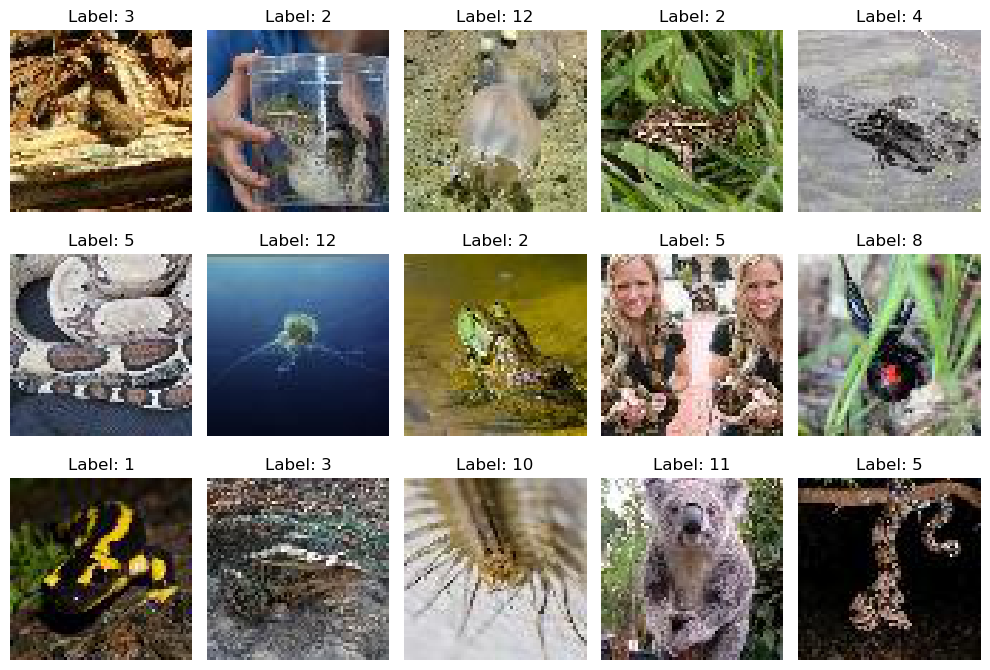

In [13]:
# graficamos algunas imagenes para saber con que tipo de datos estamos trabajando
import matplotlib.pyplot as plt
import random

def show_random_images(dataset, num_rows, num_columns):
    # Crear una figura y ejes para la tabla de imágenes
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 7))

    for i in range(num_rows):
        for j in range(num_columns): 
            # Elegir aleatoriamente una imagen del conjunto de entrenamiento
            random_index = random.randint(0, len(dataset['train']) - 1) 
            random_image = dataset['train'][random_index]['image'] 
            random_label = dataset['train'][random_index]['label'] 

            # Mostrar la imagen en el subgráfico correspondiente
            axes[i, j].imshow(random_image, interpolation='nearest')
            axes[i, j].set_title(f"Label: {random_label}")
            axes[i, j].axis('off')  # Ocultar los ejes

    # Ajustar el espacio entre los subgráficos para que se vean bien
    plt.tight_layout()
    # Mostrar la tabla de imágenes
    plt.show()

# Llamar a la función con tu dataset
show_random_images(dataset_ti, 3, 5)


### Transformaciones 

En esta sección, implementamos algunas transformaciones que deseamos aplicar a las imágenes. En nuestro caso, estas transformaciones incluyen las siguientes:

In [14]:
class EnsureRGBChannels:
    def __call__(self, image):
        if image.mode != 'RGB':
            image = image.convert('RGB')
        return image

# Define una transformación que deseas aplicar a las imágenes para el aumento de datos.
# Puedes agregar múltiples transformaciones según tus necesidades.
transform = transforms.Compose([
    EnsureRGBChannels(), # Asegura que la imagen tenga 3 canales RGB
    transforms.RandomHorizontalFlip(), # Voltear horizontalmente la imagen
    transforms.RandomRotation(10), # Rotar la imagen aleatoriamente en un ángulo de 10 grados
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Cambiar el brillo, contraste y saturación de la imagen
    transforms.RandomCrop(60, padding=2), # Recortar la imagen aleatoriamente a un tamaño de 60x60 píxeles
    transforms.Resize(64), # Cambiar el tamaño de la imagen a 64x64 píxeles
    transforms.ToTensor(), # Convertir la imagen a un tensor de PyTorch
])

### Dataset Custom

Esta clase facilitará el manejo de nuestro conjunto de datos, simplificando las operaciones y la interacción con él.

In [15]:
class CustomDataset(Dataset):
    def __init__(self, dataset, split, transform=None, data_augmentation=False, num_transforms=1):
        self.X = dataset[split]['image']  # cargar imágenes
        self.y = dataset[split]['label']  # cargar etiquetas
        self.transform = transform
        self.num_transforms = num_transforms

        # Duplica las imágenes en el conjunto de entrenamiento si data_augmentation es True
        if split == 'train' and data_augmentation or split == 'valid' and data_augmentation:
            self.X *= self.num_transforms 
            self.y *= self.num_transforms

    # Devuelve el número de muestras en el conjunto de datos.
    def __len__(self):
        return len(self.X)

    # Devuelve una muestra del conjunto de datos en la posición index.
    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]
        # Aplica el transformador a la imagen si está definido
        if self.transform:
            img = self.transform(img)

        return img, label

In [16]:
# Creamos el conjunto de datos de entrenamiento y de prueba con la clase CustomDataset que definimos anteriormente 
dataset = {
    'train' : CustomDataset(dataset_ti, 'train', transform=transform, data_augmentation=True, num_transforms=5),
    'test' : CustomDataset(dataset_ti, 'valid', transform=transform, data_augmentation=True, num_transforms=5)
}

len(dataset['train']), len(dataset['test'])

(37500, 3750)

In [17]:
# mostrar las dimensiones de una imagen del conjunto de datos de entrenamiento
dataset['train'][0][0].shape

torch.Size([3, 64, 64])

Estamos mostrando una imagen para determinar si está normalizadas o no.

In [18]:
dataset['train'][0]

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.2784, 0.0000, 0.0000],
          [0.9961, 0.9412, 0.9255,  ..., 0.3490, 0.0000, 0.0000],
          ...,
          [0.3412, 0.3490, 0.3176,  ..., 0.2824, 0.2863, 0.0000],
          [0.3529, 0.3333, 0.2980,  ..., 0.0000, 0.0000, 0.0000],
          [0.3333, 0.3176, 0.3059,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.6118, 0.6549, 0.6980,  ..., 0.0000, 0.0000, 0.0000],
          [0.6667, 0.7137, 0.7294,  ..., 0.3922, 0.0000, 0.0000],
          [0.6980, 0.6863, 0.7216,  ..., 0.4745, 0.0000, 0.0000],
          ...,
          [0.4667, 0.4510, 0.4157,  ..., 0.2667, 0.2667, 0.0000],
          [0.4824, 0.4353, 0.3922,  ..., 0.0000, 0.0000, 0.0000],
          [0.4588, 0.4196, 0.4000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.7922, 0.8314, 0.8627,  ..., 0.0000, 0.0000, 0.0000],
          [0.8039, 0.8235, 0.8196,  ..., 0.3373, 0.0000, 0.0000],
          [0.8157, 0.7804, 0.7843,  ...,

In [19]:
# Inicializa las variables para el valor máximo y mínimo
max_value = float('-inf')  # Inicializa con un valor negativo infinito
min_value = float('inf')   # Inicializa con un valor positivo infinito

# Itera a través de los lotes en el DataLoader
for batch in dataset['train']:
    # Desempaqueta el lote en características (X) y etiquetas (y)
    X, y = batch
    
    # Encuentra el valor máximo y mínimo en el lote actual
    batch_max = torch.max(X)
    batch_min = torch.min(X)
    
    # Actualiza el valor máximo y mínimo global si es necesario
    max_value = max(max_value, batch_max) # type: ignore
    min_value = min(min_value, batch_min) # type: ignore

# Ahora 'max_value' contiene el valor máximo en todo el conjunto de datos
# y 'min_value' contiene el valor mínimo en todo el conjunto de datos.

print(f"Valor máximo: {max_value}")
print(f"Valor mínimo: {min_value}")

Valor máximo: 1.0
Valor mínimo: 0.0


En este caso, el conjunto de datos se encuentra ya normalizado, por lo tanto, no es necesario realizar ninguna normalización adicional. Las imágenes están listas para ser utilizadas en el proceso de entrenamiento.

### Dataloader

Hemos creado un DataLoader personalizado para gestionar nuestros datos de manera más eficiente y conveniente. Esto nos permitirá realizar un mejor manejo de los datos al cargarlos y procesarlos de manera adecuada para el entrenamiento de nuestro modelo ResNeXt50 desde cero.

In [20]:
dataloader = {
    'train': DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape, labels.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

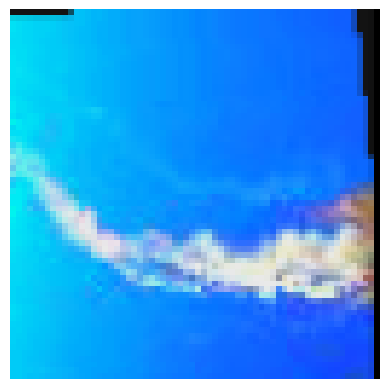

In [13]:
# Obtén un lote de datos del DataLoader (por ejemplo, el conjunto de entrenamiento)
for batch in dataloader['train']:
    images, labels = batch
    break  # Sal del bucle después de obtener el primer lote

# Supongamos que deseas mostrar la primera imagen del lote
image_to_show = images[0]  # type: ignore
# Convierte el tensor de imagen de PyTorch a un arreglo NumPy
image_to_show = image_to_show.permute(1, 2, 0).numpy()  # Cambia el orden de las dimensiones

# Muestra la imagen utilizando Matplotlib
plt.imshow(image_to_show)
plt.axis('off')  # Oculta los ejes
plt.show()


### Modelo pre entrenado

Vamos a utilizar el modelo ResNeXt50 en este laboratorio. La elección de este modelo se debe a sus capacidades y rendimiento probados en tareas de visión por computadora. ResNeXt50 es conocido por su profundidad y habilidad para aprender representaciones de alta calidad de datos visuales complejos.

Dado que nuestro conjunto de datos ya está normalizado y listo para el entrenamiento, la elección de ResNeXt50 nos brinda una base sólida para abordar nuestra tarea de clasificación de imágenes con confianza.

In [14]:
# Cargar el modelo preentrenado resnext50_32x4d
model = models.resnext50_32x4d(pretrained=True)
model

c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [15]:
class ModelCustom(torch.nn.Module):
  def __init__(self, n_outputs=15, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnext
    resnext = models.resnext50_32x4d(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnext = nn.Sequential(*list(resnext.children())[:-1])
    if freeze:
      for param in self.resnext.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = nn.Linear(2048, n_outputs)

  def forward(self, x):
    x = self.resnext(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnext.parameters():
        param.requires_grad=True

In [16]:
# hacemos la prueba de que nuestro modelo funciona correctamente
model_custom = ModelCustom()
outputs = model_custom(torch.randn(64, 3, 64, 64))
outputs.shape

c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([64, 15])

### Entreamiento

Hemos implementado la función `fit` para entrenar nuestro modelo, tal como mencionamos anteriormente. En este caso, estamos realizando un entrenamiento desde cero de nuestra red neuronal basada en el modelo ResNeXt50.

In [17]:
import numpy as np
from sklearn.metrics import accuracy_score

def fit(model, dataloader, epochs=5, lr_resnet=1e-4, lr_fc=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam([{'params': model.resnext.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}])
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y) 
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch 
                X, y = X.to(device), y.to(device) 
                y_hat = model(X) 
                loss = criterion(y_hat, y) 
                val_loss.append(loss.item()) 
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y) # type: ignore
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [18]:
# Entrenando con finetuning (Congelando y Descongelando), entrenamos solo la capa de salida (fc) y luego todas las capas
model = ModelCustom(pretrained=True, freeze=True)

c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
# entrenamos solo la capa de salida (fc) y luego todas las capas
fit(model, dataloader, epochs=7, lr_resnet=1e-4, lr_fc=0.001)
model.unfreeze()
fit(model, dataloader, epochs=5, lr_resnet=1e-4, lr_fc=0.001)
# acc 0.96931 val_acc 0.75358

val_loss 1.54762 val_acc 0.52252: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


Epoch 1/7 loss 1.58571 val_loss 1.54762 acc 0.50646 val_acc 0.52252


val_loss 1.54856 val_acc 0.52696: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


Epoch 2/7 loss 1.41588 val_loss 1.54856 acc 0.55836 val_acc 0.52696


val_loss 1.45621 val_acc 0.55558: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


Epoch 3/7 loss 1.38231 val_loss 1.45621 acc 0.56749 val_acc 0.55558


val_loss 1.49274 val_acc 0.54159: 100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


Epoch 4/7 loss 1.35020 val_loss 1.49274 acc 0.57571 val_acc 0.54159


val_loss 1.51118 val_acc 0.54287: 100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


Epoch 5/7 loss 1.32994 val_loss 1.51118 acc 0.58202 val_acc 0.54287


val_loss 1.50248 val_acc 0.54817: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


Epoch 6/7 loss 1.32045 val_loss 1.50248 acc 0.58283 val_acc 0.54817


val_loss 1.50585 val_acc 0.53386: 100%|██████████| 15/15 [00:04<00:00,  3.29it/s]


Epoch 7/7 loss 1.30611 val_loss 1.50585 acc 0.59067 val_acc 0.53386


val_loss 0.92968 val_acc 0.73895: 100%|██████████| 15/15 [00:04<00:00,  3.25it/s]


Epoch 1/5 loss 0.67087 val_loss 0.92968 acc 0.79316 val_acc 0.73895


val_loss 1.11895 val_acc 0.75509: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


Epoch 2/5 loss 0.23480 val_loss 1.11895 acc 0.92459 val_acc 0.75509


val_loss 1.20700 val_acc 0.74091: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


Epoch 3/5 loss 0.13881 val_loss 1.20700 acc 0.95638 val_acc 0.74091


val_loss 1.06704 val_acc 0.76742: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


Epoch 4/5 loss 0.12393 val_loss 1.06704 acc 0.96205 val_acc 0.76742


val_loss 1.21222 val_acc 0.75308: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]

Epoch 5/5 loss 0.08735 val_loss 1.21222 acc 0.97365 val_acc 0.75308
